In [67]:
# Imports / loading data
import json 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import pandas as pd
from scipy import stats

from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu


## LLaMA-3-8b data
with open('/Users/ninaliem/thesis_master/results/rq1/llms_Meta-Llama-3-8B_FEMALE_logits_2811_2.json', 'r') as f1:
    data1 = json.load(f1)

with open('/Users/ninaliem/thesis_master/results/rq1/llms_Meta-Llama-3-8B_MALE_logits_312_2.json', 'r') as f2:
    data2 = json.load(f2)

with open('/Users/ninaliem/thesis_master/results/rq1/llms_Meta-Llama-3-8B_NEUT_logits_312_2.json', 'r') as f3:
    data3 = json.load(f3)

llama38b_data = {**data1, **data2, **data3}

## LLaMA-2-7b data
with open('/Users/ninaliem/thesis_master/results/rq1/Meta-Llama-2-7B_FEMALE_logits_2811_2.json', 'r') as f1:
    data4 = json.load(f1)

with open('/Users/ninaliem/thesis_master/results/rq1/Meta-Llama-2-7B_MALE_logits_312_2.json', 'r') as f2:
    data5 = json.load(f2)

with open('/Users/ninaliem/thesis_master/results/rq1/Meta-Llama-2-7B_NEUT_logits_312_2.json', 'r') as f3:
    data6 = json.load(f3)

llama27b_data = {**data4, **data5, **data6}

# Load AQ-27-f JSON file
with open("/Users/ninaliem/thesis_master/data/aq27_data.json", "r") as f:
    aq27_data = json.load(f)

In [68]:
def softmax(logit_pair):
    exp_logit_1 = np.exp(logit_pair[0])
    exp_logit_2 = np.exp(logit_pair[1])
    total = exp_logit_1 + exp_logit_2
    prob_1 = exp_logit_1 / total
    prob_2 = exp_logit_2 / total
    return prob_1, prob_2

def process_data(data, key):
    results = {}

    for diagnosis, vignettes in data.items():
        for vignette, statements in vignettes.items():
            for statement, values in statements.items():
                logits = values['logits']
                if statement not in results:
                    results[statement] = {}
                if diagnosis not in results[statement]:
                    results[statement][diagnosis] = []
                results[statement][diagnosis].append((logits['Agree'], logits['Disagree']))

    df = pd.DataFrame.from_dict(results, orient="index")
    df.columns = [f"{col} (logit pair)" for col in df.columns]
    statement_to_dimension = {item[0]: item[1] for item in aq27_data[key]["statements"]}
    dimension_results = {}

    for statement, logits in results.items():  # 'results' from previous code
        dimension = statement_to_dimension.get(statement)
        if dimension:
            if dimension not in dimension_results:
                dimension_results[dimension] = {}
            for diagnosis, logit_pairs in logits.items():
                if diagnosis not in dimension_results[dimension]:
                    dimension_results[dimension][diagnosis] = {"logit_pairs": []}
                dimension_results[dimension][diagnosis]["logit_pairs"].extend(logit_pairs)

    dimension_summary = {}

    for dimension, diagnoses in dimension_results.items():
        dimension_summary[dimension] = {
            diagnosis: (
                values["logit_pairs"]  # List of all logit pairs
            )
            for diagnosis, values in diagnoses.items()
        }

    df_dimension = pd.DataFrame.from_dict(dimension_summary, orient="index")
    df_dimension.columns = [f"{col} (logit pairs)" for col in df_dimension.columns]

    flattened_data = {
        'Dimension': [],
        'Diagnosis': [],
        'Agree_Prob': [],
        'Disagree_Prob': []
    }

    for dimension, diagnoses in dimension_results.items():
        for diagnosis, values in diagnoses.items():
            for logit_pair in values['logit_pairs']:
                prob_1, prob_2 = softmax(logit_pair)
                flattened_data['Dimension'].append(dimension)
                flattened_data['Diagnosis'].append(diagnosis)
                
                if dimension == "Avoidance":
                    flattened_data['Agree_Prob'].append(prob_2)  
                    flattened_data['Disagree_Prob'].append(prob_1) 
                else:
                    flattened_data['Agree_Prob'].append(prob_1)  
                    flattened_data['Disagree_Prob'].append(prob_2)  

    df_flat = pd.DataFrame(flattened_data)

    return df_flat


In [69]:
df_flat_female = process_data(data1, "AQ-27-f")
df_flat_male = process_data(data2, "AQ-27-m")
df_flat_neutral = process_data(data3, "AQ-27-they")

df_flat_female['Gender'] = 'Female'
df_flat_male['Gender'] = 'Male'
df_flat_neutral['Gender'] = 'Neutral'

df_flat_female['Model'] = 'LLaMA-3-8b'
df_flat_male['Model'] = 'LLaMA-3-8b'
df_flat_neutral['Model'] = 'LLaMA-3-8b'

df_flat_female_456 = process_data(data4, "AQ-27-f")  
df_flat_male_456 = process_data(data5, "AQ-27-m")  
df_flat_neutral_456 = process_data(data6, "AQ-27-they")  

df_flat_female_456['Gender'] = 'Female'
df_flat_male_456['Gender'] = 'Male'
df_flat_neutral_456['Gender'] = 'Neutral'

df_flat_female_456['Model'] = 'LLaMA-2-7b'
df_flat_male_456['Model'] = 'LLaMA-2-7b'
df_flat_neutral_456['Model'] = 'LLaMA-2-7b'

df_combined = pd.concat([df_flat_female, df_flat_male, df_flat_neutral, 
                         df_flat_female_456, df_flat_male_456, df_flat_neutral_456], 
                        ignore_index=True)



In [70]:
common_disorders = ['anxiety disorder', 'depression', 'posttraumatic stress disorder', 'obsessive-compulsive disorder']

df_combined['Severity'] = df_combined['Diagnosis'].apply(
    lambda x: 'Common' if x in common_disorders else 'Severe'
)

# Gender comparison


In [71]:
gender_comparison = df_combined.groupby(['Model', 'Gender'])[['Agree_Prob', 'Disagree_Prob']].mean()

gender_comparison


Agree_Prob  Disagree_Prob
Model      Gender                            
LLaMA-2-7b Female     0.541538       0.458462
           Male       0.540861       0.459139
           Neutral    0.552926       0.447074
LLaMA-3-8b Female     0.274209       0.725791
           Male       0.275499       0.724501
           Neutral    0.267246       0.732754

/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


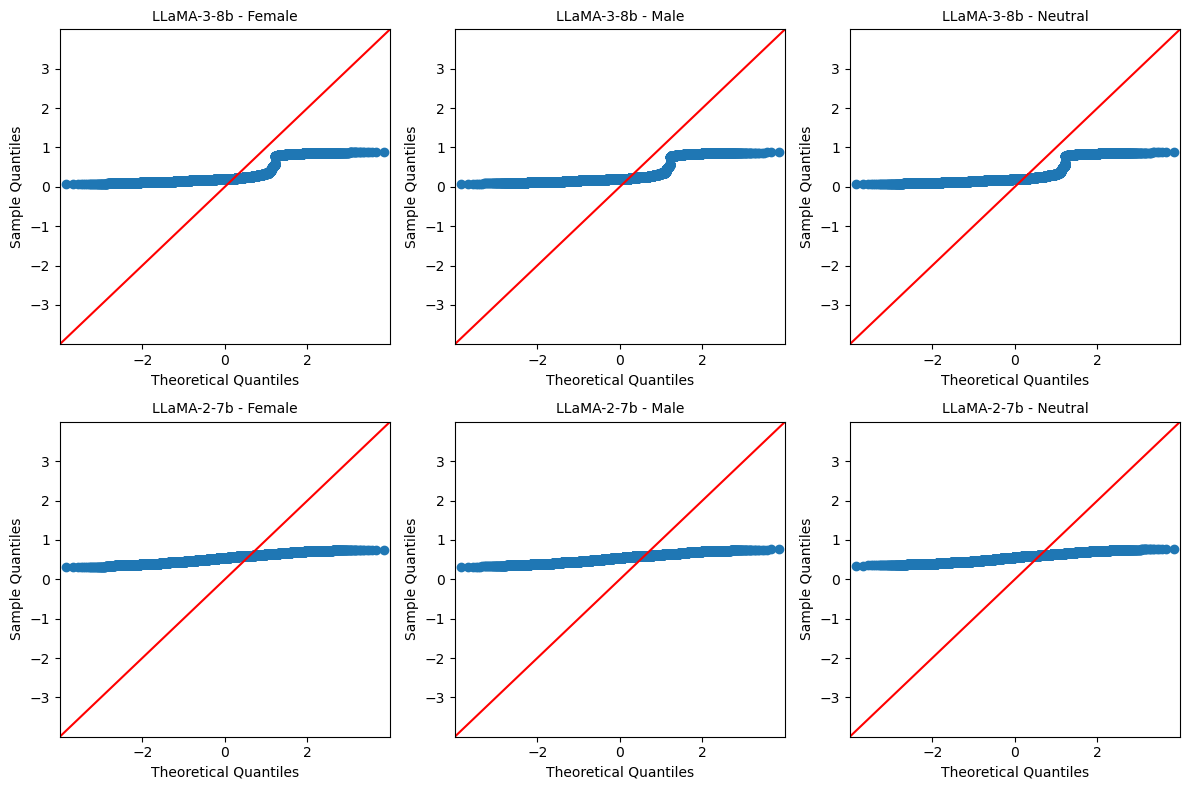

defaultdict(dict,
            {'LLaMA-3-8b': {'Female': {'Shapiro-Wilk Stat': 0.6466270685195923,
               'P-value': 0.0},
              'Male': {'Shapiro-Wilk Stat': 0.6371541023254395,
               'P-value': 0.0},
              'Neutral': {'Shapiro-Wilk Stat': 0.6391031742095947,
               'P-value': 0.0}},
             'LLaMA-2-7b': {'Female': {'Shapiro-Wilk Stat': 0.9926134943962097,
               'P-value': 4.05329819796528e-28},
              'Male': {'Shapiro-Wilk Stat': 0.9921377897262573,
               'P-value': 6.188136291203251e-29},
              'Neutral': {'Shapiro-Wilk Stat': 0.9883193969726562,
               'P-value': 2.124343977667682e-34}}})

In [72]:
df_combined['Agree_Prob'] = df_combined['Agree_Prob'].round(2)

models = df_combined['Model'].unique()
genders = df_combined['Gender'].unique()

normality_results = defaultdict(dict)

n_rows = len(models)
n_cols = len(genders)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))

axes = np.atleast_2d(axes)

for row, model in enumerate(models):
    model_data = df_combined[df_combined['Model'] == model]

    for col, gender in enumerate(genders):
        gender_data = model_data[model_data['Gender'] == gender]['Agree_Prob']

        if len(gender_data) > 3:  
            stat, p_value = shapiro(gender_data)
            normality_results[model][gender] = {'Shapiro-Wilk Stat': stat, 'P-value': p_value}
        
        ax = axes[row, col]
        qqplot(gender_data, line='45', ax=ax)
        ax.set_title(f'{model} - {gender}', fontsize=10)

plt.tight_layout()
plt.show()

normality_results


--> We assessed normality using Shapiro-Wilk & QQ-plots. Found normality assumption was violated for aggregated gender data. Thus we proceed with a non-parametric test.

In [73]:
df_combined['Agree_Prob'] = df_combined['Agree_Prob'].round(2)

positive_dimensions = ['Help', 'Pity']  # Define positive dimensions
negative_dimensions = ['Anger', 'Coercion', 'Blame', 'Dangerousness', 'Fear', 'Segregation', 'Avoidance']  # Define negative dimensions

df_positive = df_combined[df_combined['Dimension'].isin(positive_dimensions)]
df_negative = df_combined[df_combined['Dimension'].isin(negative_dimensions)]

Mann-Whitney U + Cliff's delta, positive dimensions

In [75]:
genders = df_combined['Gender'].unique()

cliffs_delta_results = {}

for model in df_positive['Model'].unique():
    model_data = df_positive[df_positive['Model'] == model]
    
    for i, gender_1 in enumerate(genders):
        for gender_2 in genders[i+1:]:  
            group_1 = model_data[model_data['Gender'] == gender_1]['Agree_Prob']
            group_2 = model_data[model_data['Gender'] == gender_2]['Agree_Prob']
            
            u_stat, _ = mannwhitneyu(group_1, group_2, alternative='two-sided')
            print(gender_1, gender_2, "U: ", u_stat, "p: ", _)
            
            n_1 = len(group_1)
            n_2 = len(group_2)
            
            cliffs_delta_value = (2 * u_stat - n_1 * n_2) / (n_1 * n_2)
            
            if model not in cliffs_delta_results:
                cliffs_delta_results[model] = {}
            
            cliffs_delta_results[model][f'{gender_1} vs {gender_2}'] = cliffs_delta_value

cliffs_delta_results

Female Male U:  6758237.0 p:  0.8562316055504685
Female Neutral U:  7297585.0 p:  9.189706950453534e-10
Male Neutral U:  7294252.5 p:  1.1542300947988261e-09
Female Male U:  7073052.0 p:  0.00026105455265740637
Female Neutral U:  5948911.5 p:  2.3595048106884785e-18
Male Neutral U:  5577296.5 p:  1.0397612111560066e-37


{'LLaMA-3-8b': {'Female vs Male': 0.0024392624394226343,
  'Female vs Neutral': 0.08243995068373512,
  'Male vs Neutral': 0.08194564590542099},
 'LLaMA-2-7b': {'Female vs Male': 0.04913530408532331,
  'Female vs Neutral': -0.11760678763153773,
  'Male vs Neutral': -0.1727278889648331}}

Mann-Whitney U + Cliff's delta, negative dimensions

In [76]:
genders = df_combined['Gender'].unique()

cliffs_delta_results = {}

for model in df_negative['Model'].unique():
    model_data = df_negative[df_negative['Model'] == model]
    
    for i, gender_1 in enumerate(genders):
        for gender_2 in genders[i+1:]:  
            # Get the data for each diagnosis group
            group_1 = model_data[model_data['Gender'] == gender_1]['Agree_Prob']
            group_2 = model_data[model_data['Gender'] == gender_2]['Agree_Prob']
            
            u_stat, _ = mannwhitneyu(group_1, group_2, alternative='two-sided')
            print(gender_1, gender_2, "U: ", u_stat, "p: ", _)

            n_1 = len(group_1)
            n_2 = len(group_2)
            
            cliffs_delta_value = (2 * u_stat - n_1 * n_2) / (n_1 * n_2)
            
            if model not in cliffs_delta_results:
                cliffs_delta_results[model] = {}
            
            cliffs_delta_results[model][f'{gender_1} vs {gender_2}'] = cliffs_delta_value

cliffs_delta_results

Female Male U:  79687598.5 p:  1.0472143813831065e-06
Female Neutral U:  87800398.0 p:  1.6572412478389468e-18
Male Neutral U:  90849482.0 p:  5.222026814173271e-44
Female Male U:  82432593.0 p:  0.7951007817693935
Female Neutral U:  76802494.5 p:  2.211696294743548e-22
Male Neutral U:  76824958.5 p:  3.1919789772427153e-22


{'LLaMA-3-8b': {'Female vs Male': -0.03510667762626716,
  'Female vs Neutral': 0.06312675154787163,
  'Male vs Neutral': 0.10004643348503768},
 'LLaMA-2-7b': {'Female vs Male': -0.0018690482729039328,
  'Female vs Neutral': -0.0700408158906264,
  'Male vs Neutral': -0.06976881166409919}}

# Diagnosis comparison

In [ ]:
custom_order_fullnames = [
    "anxiety disorder",
    "depression",
    "posttraumatic stress disorder",
    "obsessive compulsive disorder",
    "antisocial personality disorder",
    "schizophrenia",
    "bipolar-2",
    "borderline personality disorder",
    "dissociative identity disorder"
]

ordered_dimensions = ['Anger', 'Avoidance', 'Blame', 'Coercion', 'Dangerousness', 'Fear', 'Segregation', 'Help', 'Pity']

df_combined['Dimension'] = pd.Categorical(df_combined['Dimension'], categories=ordered_dimensions, ordered=True)

df_combined['Diagnosis'] = pd.Categorical(df_combined['Diagnosis'], categories=custom_order_fullnames, ordered=True)

df_combined['Diagnosis'] = df_combined['Diagnosis'].replace({
    "anxiety disorder" : "ANX",
    "depression": "DEPR",
    "posttraumatic stress disorder" : "PTSD",
    "obsessive compulsive disorder" : "OCD",
    "antisocial personality disorder" : "APD",
    "schizophrenia" : "SCHI",
    "bipolar-2" : "BIP-II",
    "borderline personality disorder" : "BPD",
    "dissociative identity disorder" : "DID"
})

agg_data = df_combined.groupby(['Model', 'Diagnosis', 'Dimension'])['Agree_Prob'].mean().unstack()

agg_data = agg_data.fillna(0) 
agg_data.round(2)

Dimension             Anger  Avoidance  Blame  Coercion  Dangerousness  Fear  \
Model      Diagnosis                                                           
LLaMA-2-7b ANX         0.65       0.46   0.48      0.55           0.62  0.63   
           DEPR        0.56       0.49   0.45      0.50           0.54  0.57   
           PTSD        0.59       0.48   0.43      0.50           0.56  0.58   
           OCD         0.62       0.47   0.47      0.55           0.60  0.62   
           APD         0.62       0.54   0.46      0.53           0.58  0.59   
           SCHI        0.60       0.52   0.46      0.53           0.59  0.62   
           BIP-II      0.63       0.42   0.52      0.55           0.59  0.62   
           BPD         0.60       0.49   0.45      0.52           0.57  0.59   
           DID         0.56       0.53   0.40      0.48           0.53  0.54   
LLaMA-3-8b ANX         0.17       0.82   0.16      0.14           0.14  0.16   
           DEPR        0.22       0.81   0.19      0.17           0.19  0.20   
           PTSD        0.21       0.81   0.14      0.15           0.16  0.17   
           OCD         0.20       0.83   0.16      0.20           0.17  0.19   
           APD         0.29       0.83   0.21      0.21           0.25  0.24   
           SCHI        0.23       0.83   0.19      0.21           0.25  0.26   
           BIP-II      0.19       0.83   0.17      0.14           0.17  0.18   
           BPD         0.21       0.84   0.15      0.15           0.17  0.18   
           DID         0.18       0.80   0.16      0.18           0.16  0.19   

Dimension             Segregation  Help  Pity  
Model      Diagnosis                           
LLaMA-2-7b ANX               0.46  0.69  0.68  
           DEPR              0.41  0.62  0.61  
           PTSD              0.41  0.62  0.61  
           OCD               0.45  0.65  0.64  
           APD               0.45  0.56  0.55  
           SCHI              0.48  0.59  0.58  
           BIP-II            0.46  0.65  0.63  
           BPD               0.44  0.59  0.61  
           DID               0.38  0.56  0.55  
LLaMA-3-8b ANX               0.11  0.29  0.34  
           DEPR              0.16  0.32  0.40  
           PTSD              0.12  0.28  0.35  
           OCD               0.15  0.27  0.34  
           APD               0.21  0.19  0.21  
           SCHI              0.20  0.24  0.31  
           BIP-II            0.13  0.17  0.21  
           BPD               0.12  0.20  0.23  
           DID               0.16  0.27  0.28

# Normality check

/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


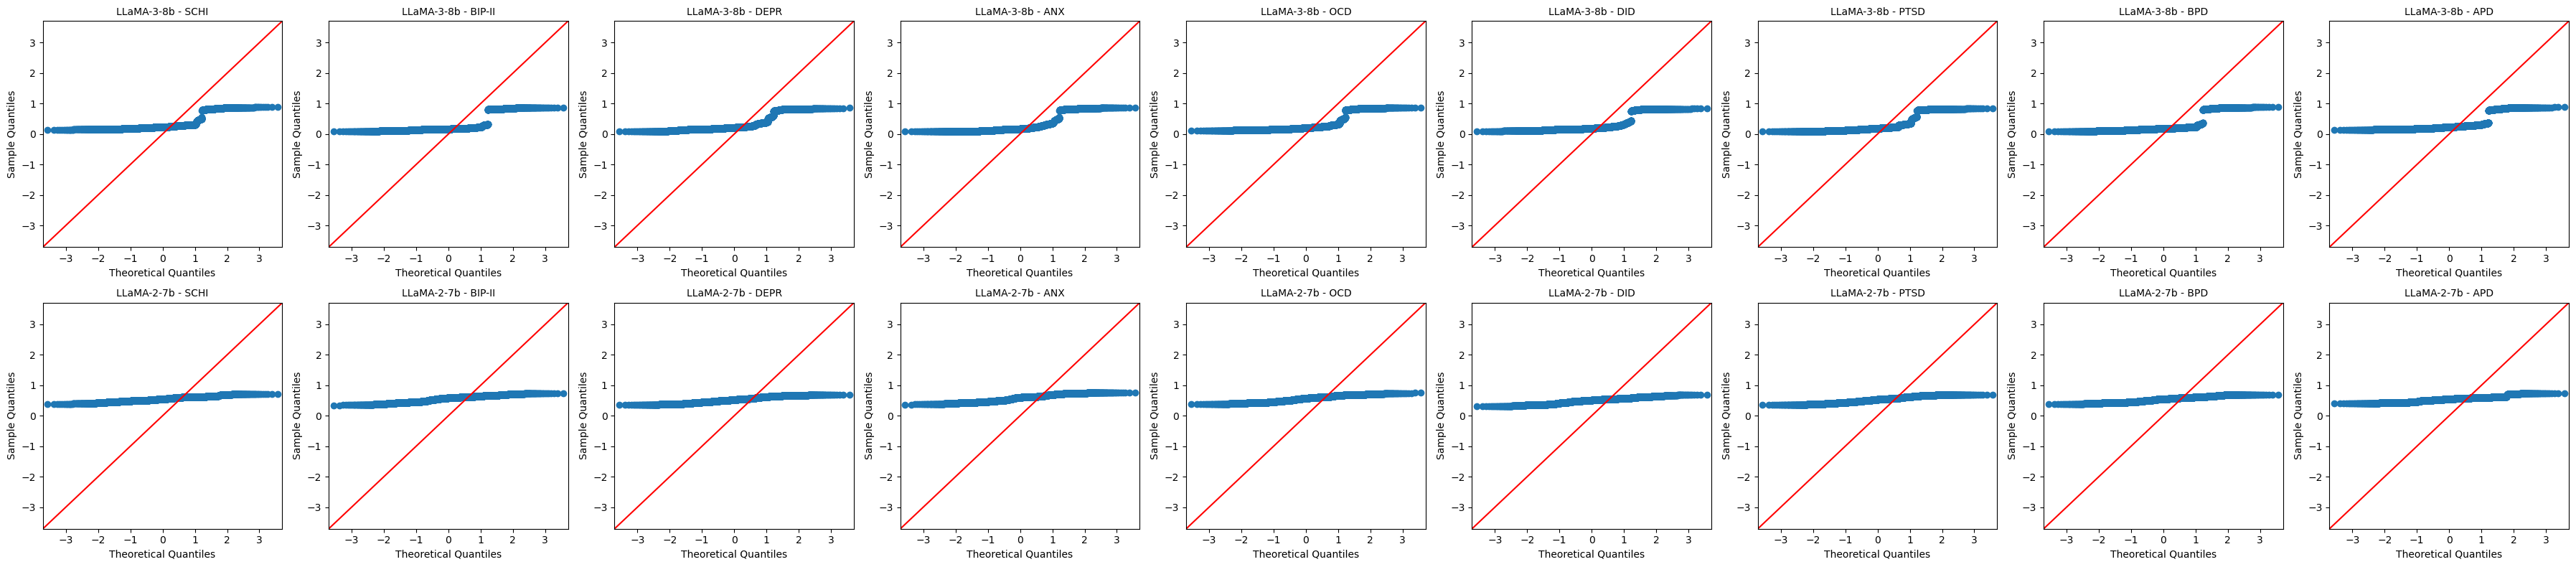

defaultdict(dict,
            {'LLaMA-3-8b': {'SCHI': {'Shapiro-Wilk Stat': 0.6118454337120056,
               'P-value': 0.0},
              'BIP-II': {'Shapiro-Wilk Stat': 0.5216911435127258,
               'P-value': 0.0},
              'DEPR': {'Shapiro-Wilk Stat': 0.698405385017395, 'P-value': 0.0},
              'ANX': {'Shapiro-Wilk Stat': 0.6746933460235596, 'P-value': 0.0},
              'OCD': {'Shapiro-Wilk Stat': 0.632260799407959, 'P-value': 0.0},
              'DID': {'Shapiro-Wilk Stat': 0.6072710752487183, 'P-value': 0.0},
              'PTSD': {'Shapiro-Wilk Stat': 0.6744246482849121,
               'P-value': 0.0},
              'BPD': {'Shapiro-Wilk Stat': 0.5467109680175781, 'P-value': 0.0},
              'APD': {'Shapiro-Wilk Stat': 0.5904143452644348,
               'P-value': 0.0}},
             'LLaMA-2-7b': {'SCHI': {'Shapiro-Wilk Stat': 0.9825905561447144,
               'P-value': 1.727153513046744e-25},
              'BIP-II': {'Shapiro-Wilk Stat': 0.9567962

In [ ]:
df_combined['Agree_Prob'] = df_combined['Agree_Prob'].round(2)
models = df_combined['Model'].unique()
diagnoses = df_combined['Diagnosis'].unique()
normality_results = defaultdict(dict)

n_rows = len(models)
n_cols = len(diagnoses)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))

axes = np.atleast_2d(axes)

for row, model in enumerate(models):
    model_data = df_combined[df_combined['Model'] == model]

    for col, diagnosis in enumerate(diagnoses):
        diagnosis_data = model_data[model_data['Diagnosis'] == diagnosis]['Agree_Prob']

        if len(diagnosis_data) > 3:  
            stat, p_value = shapiro(diagnosis_data)
            normality_results[model][diagnosis] = {'Shapiro-Wilk Stat': stat, 'P-value': p_value}
        
        ax = axes[row, col]
        qqplot(diagnosis_data, line='45', ax=ax)
        ax.set_title(f'{model} - {diagnosis}', fontsize=10)

plt.tight_layout()
plt.show()

normality_results


Normality is violated. Proceed with non-parametric test: Kruskal Wallis, as we compare more than two groups (n > 2 diagnoses).

First separate positive and negative dimensions.

In [53]:
from scipy.stats import kruskal

df_combined['Agree_Prob'] = df_combined['Agree_Prob'].round(2)

positive_dimensions = ['Help', 'Pity']  # Define positive dimensions
negative_dimensions = ['Anger', 'Coercion', 'Blame', 'Dangerousness', 'Fear', 'Segregation', 'Avoidance']  # Define negative dimensions

df_positive = df_combined[df_combined['Dimension'].isin(positive_dimensions)]
df_negative = df_combined[df_combined['Dimension'].isin(negative_dimensions)]


**Kruskal Wallis, negative dimensions** 

In [54]:
kruskal_results = {}

for model in df_negative['Model'].unique():
    model_data = df_negative[df_negative['Model'] == model]
    
    diagnosis_groups = [model_data[model_data['Diagnosis'] == diagnosis]['Agree_Prob'] for diagnosis in diagnoses]
    
    H_statistic, p_value = kruskal(*diagnosis_groups)
    kruskal_results[model] = {'H-statistic': H_statistic, 'P-value': p_value}

kruskal_results

{'LLaMA-3-8b': {'H-statistic': 6429.698219227561, 'P-value': 0.0},
 'LLaMA-2-7b': {'H-statistic': 2403.9646270725393, 'P-value': 0.0}}

The Kruskal-Wallis test was highly significant (p = 0.0) for both models, which confirms that at least one diagnosis group differs within each model in terms of handling the negative dimensions (anger, fear, etc.).

We use Cliff's delta for effect size and do a pairwise comparison of the diagnoses using Mann Whitney U, a nonparametric test that compares two groups.

In [41]:
from scipy.stats import mannwhitneyu

diagnoses = df_combined['Diagnosis'].unique()

cliffs_delta_results = {}

for model in df_negative['Model'].unique():
    model_data = df_negative[df_negative['Model'] == model]
    
    for i, diagnosis_1 in enumerate(diagnoses):
        for diagnosis_2 in diagnoses[i+1:]:  # Compare each pair of diagnoses
            group_1 = model_data[model_data['Diagnosis'] == diagnosis_1]['Agree_Prob']
            group_2 = model_data[model_data['Diagnosis'] == diagnosis_2]['Agree_Prob']
            
            u_stat, _ = mannwhitneyu(group_1, group_2, alternative='two-sided')
            
            n_1 = len(group_1)
            n_2 = len(group_2)
            
            cliffs_delta_value = (2 * u_stat - n_1 * n_2) / (n_1 * n_2)
            
            if model not in cliffs_delta_results:
                cliffs_delta_results[model] = {}
            
            cliffs_delta_results[model][f'{diagnosis_1} vs {diagnosis_2}'] = cliffs_delta_value

cliffs_delta_results

{'LLaMA-3-8b': {'SCHI vs BIP-II': 0.5052418026033944,
  'SCHI vs DEPR': 0.3139710677299242,
  'SCHI vs ANX': 0.5961517504605328,
  'SCHI vs OCD': 0.39622799010671805,
  'SCHI vs DID': 0.48006419343336465,
  'SCHI vs PTSD': 0.5142431700348985,
  'SCHI vs BPD': 0.4931556500595881,
  'SCHI vs APD': -0.09407314123906643,
  'BIP-II vs DEPR': -0.24522984575093654,
  'BIP-II vs ANX': 0.20452489274576932,
  'BIP-II vs OCD': -0.15217050872636637,
  'BIP-II vs DID': -0.055447233359574764,
  'BIP-II vs PTSD': 0.06687299102647595,
  'BIP-II vs BPD': 0.0081404566183772,
  'BIP-II vs APD': -0.573101408319319,
  'DEPR vs ANX': 0.3922036679595586,
  'DEPR vs OCD': 0.10515121081112183,
  'DEPR vs DID': 0.20184778704510126,
  'DEPR vs PTSD': 0.28182765480920036,
  'DEPR vs BPD': 0.246425748948817,
  'DEPR vs APD': -0.41902169364477815,
  'ANX vs OCD': -0.3286740622174796,
  'ANX vs DID': -0.25682773109243695,
  'ANX vs PTSD': -0.11872178065125832,
  'ANX vs BPD': -0.18506253263832767,
  'ANX vs APD': -0

**Cliff's delta interpretation:**

Negligble < 0.15

Small = 0.15 < 0.33

Medium 0.33 < 0.47

Large 0.47 >


https://openpublishing.library.umass.edu/pare/article/1977/galley/1980/view/

In [42]:
def categorize_cliffs_delta(delta):
    abs_delta = abs(delta)
    if abs_delta < 0.147:
        return "Negligible"
    elif abs_delta < 0.33:
        return "Small"
    elif abs_delta < 0.474:
        return "Medium"
    else:
        return "Large"

categorized_results = {"Negligible": [], "Small": [], "Medium": [], "Large": []}

for model, comparisons in cliffs_delta_results.items():
    for comparison, delta in comparisons.items():
        category = categorize_cliffs_delta(delta)
        categorized_results[category].append(f"{model}: {comparison} (Cliff's Delta = {delta:.3f})")

for category, results in categorized_results.items():
    print(f"\n{category} Effect ({len(results)} comparisons):")
    print("\n".join(results) if results else "None")



Negligible Effect (27 comparisons):
LLaMA-3-8b: SCHI vs APD (Cliff's Delta = -0.094)
LLaMA-3-8b: BIP-II vs DID (Cliff's Delta = -0.055)
LLaMA-3-8b: BIP-II vs PTSD (Cliff's Delta = 0.067)
LLaMA-3-8b: BIP-II vs BPD (Cliff's Delta = 0.008)
LLaMA-3-8b: DEPR vs OCD (Cliff's Delta = 0.105)
LLaMA-3-8b: ANX vs PTSD (Cliff's Delta = -0.119)
LLaMA-3-8b: OCD vs DID (Cliff's Delta = 0.094)
LLaMA-3-8b: DID vs PTSD (Cliff's Delta = 0.119)
LLaMA-3-8b: DID vs BPD (Cliff's Delta = 0.072)
LLaMA-3-8b: PTSD vs BPD (Cliff's Delta = -0.059)
LLaMA-2-7b: SCHI vs BIP-II (Cliff's Delta = -0.009)
LLaMA-2-7b: SCHI vs ANX (Cliff's Delta = -0.052)
LLaMA-2-7b: SCHI vs OCD (Cliff's Delta = 0.029)
LLaMA-2-7b: SCHI vs APD (Cliff's Delta = 0.027)
LLaMA-2-7b: BIP-II vs ANX (Cliff's Delta = -0.081)
LLaMA-2-7b: BIP-II vs OCD (Cliff's Delta = 0.026)
LLaMA-2-7b: BIP-II vs APD (Cliff's Delta = 0.077)
LLaMA-2-7b: DEPR vs DID (Cliff's Delta = 0.098)
LLaMA-2-7b: DEPR vs PTSD (Cliff's Delta = -0.023)
LLaMA-2-7b: DEPR vs BPD (Cli

Largest effects are all observed for LL-3-8b:

- LLaMA-3-8b: SCHI vs BIP-II (Cliff's Delta = 0.505)
- LLaMA-3-8b: SCHI vs ANX (Cliff's Delta = 0.596)
- LLaMA-3-8b: SCHI vs DID (Cliff's Delta = 0.480)
- LLaMA-3-8b: SCHI vs PTSD (Cliff's Delta = 0.514)
- LLaMA-3-8b: SCHI vs BPD (Cliff's Delta = 0.493)
- LLaMA-3-8b: BIP-II vs APD (Cliff's Delta = -0.573)
- LLaMA-3-8b: ANX vs APD (Cliff's Delta = -0.640)
- LLaMA-3-8b: OCD vs APD (Cliff's Delta = -0.481)
- LLaMA-3-8b: DID vs APD (Cliff's Delta = -0.557)
- LLaMA-3-8b: PTSD vs APD (Cliff's Delta = -0.582)
- LLaMA-3-8b: BPD vs APD (Cliff's Delta = -0.561)

So, for negative dimensions (_anger, fear, etc._) we observe:
- SCHIZOPHRENIA has a higher probability of generating affirming responses than BIPOLAR, ANXIETY, DISSOCIATIVE IDENTITY DISORDER, PTSD and BORDERLINE. And,
- ANTISOCIAL PERSONALITY DISORDER has a higher probability of generating affirming responses than BIPOLAR, ANXIETY, OCD, DID, PTSD and BORDERLINE.



There are many differences between diagnoses, so let's compare the 'common' and 'severe' diagnoses as groups. Again, we focus on negative stigma dimensions, such as anger and fear, to see whether as a group, there is a difference in how these dimensions are handled. 

In [43]:

cliffs_delta_results_severity = {}

for model in df_negative['Model'].unique():
    model_data = df_negative[df_negative['Model'] == model]
    
    common_group = model_data[model_data['Severity'] == 'Common']['Agree_Prob']
    severe_group = model_data[model_data['Severity'] == 'Severe']['Agree_Prob']
    
    u_stat, _ = mannwhitneyu(common_group, severe_group, alternative='two-sided')
    
    n_common = len(common_group)
    n_severe = len(severe_group)
    
    cliffs_delta_value = (2 * u_stat - n_common * n_severe) / (n_common * n_severe)
    
    cliffs_delta_results_severity[model] = cliffs_delta_value

cliffs_delta_results_severity

{'LLaMA-3-8b': -0.20568476119569107, 'LLaMA-2-7b': -0.06966915609138838}

Cliff’s Delta for LLaMA-3-8b: -0.206. This is small (between 0.15 and 0.33). Severe diagnoses tend to have slightly higher Agree_Prob than Common diagnoses, but the difference is small.

Cliff’s Delta for LLaMA-2-7b: -0.070. This is negligible (less than 0.15). There is almost no difference between the Common and Severe groups in terms of Agree_Prob for this model.

**Kruskal Wallis, positive dimensions** 

In [45]:
kruskal_results = {}

for model in df_positive['Model'].unique():
    model_data = df_positive[df_positive['Model'] == model]
    
    diagnosis_groups = [model_data[model_data['Diagnosis'] == diagnosis]['Agree_Prob'] for diagnosis in diagnoses]
    
    H_statistic, p_value = kruskal(*diagnosis_groups)
    kruskal_results[model] = {'H-statistic': H_statistic, 'P-value': p_value}

kruskal_results

{'LLaMA-3-8b': {'H-statistic': 4973.511972765529, 'P-value': 0.0},
 'LLaMA-2-7b': {'H-statistic': 4696.313922414693, 'P-value': 0.0}}

Again:

The Kruskal-Wallis test was highly significant (p = 0.0) for both models, which confirms that at least one diagnosis group differs within each model in terms of handling the positive dimensions (help, pity).

We use Cliff's delta for effect size and do a pairwise comparison of the diagnoses using Mann Whitney U, a nonparametric test that compares two groups.

In [46]:
diagnoses = df_combined['Diagnosis'].unique()
cliffs_delta_results = {}

for model in df_positive['Model'].unique():
    model_data = df_positive[df_positive['Model'] == model]
    
    for i, diagnosis_1 in enumerate(diagnoses):
        for diagnosis_2 in diagnoses[i+1:]:  
            group_1 = model_data[model_data['Diagnosis'] == diagnosis_1]['Agree_Prob']
            group_2 = model_data[model_data['Diagnosis'] == diagnosis_2]['Agree_Prob']
            
            u_stat, _ = mannwhitneyu(group_1, group_2, alternative='two-sided')
            
            n_1 = len(group_1)
            n_2 = len(group_2)
            
            cliffs_delta_value = (2 * u_stat - n_1 * n_2) / (n_1 * n_2)
            
            if model not in cliffs_delta_results:
                cliffs_delta_results[model] = {}
            
            cliffs_delta_results[model][f'{diagnosis_1} vs {diagnosis_2}'] = cliffs_delta_value

cliffs_delta_results

{'LLaMA-3-8b': {'SCHI vs BIP-II': 0.7170599448929899,
  'SCHI vs DEPR': -0.6091587370242214,
  'SCHI vs ANX': -0.4320186680336623,
  'SCHI vs OCD': -0.44091281665171517,
  'SCHI vs DID': -0.20411687278397198,
  'SCHI vs PTSD': -0.30001148062710925,
  'SCHI vs BPD': 0.5261878444188133,
  'SCHI vs APD': 0.698060174505532,
  'BIP-II vs DEPR': -0.8924759173822034,
  'BIP-II vs ANX': -0.8330182835661498,
  'BIP-II vs OCD': -0.8034002680592934,
  'BIP-II vs DID': -0.7306751676705541,
  'BIP-II vs PTSD': -0.8380750993207741,
  'BIP-II vs BPD': -0.5087793423469605,
  'BIP-II vs APD': -0.24084286492374726,
  'DEPR vs ANX': 0.28987448737665,
  'DEPR vs OCD': 0.3943455241573754,
  'DEPR vs DID': 0.5056161625870391,
  'DEPR vs PTSD': 0.31393641334529454,
  'DEPR vs BPD': 0.8682037357426631,
  'DEPR vs APD': 0.8868183711393054,
  'ANX vs OCD': 0.0999014801999231,
  'ANX vs DID': 0.26778495984450423,
  'ANX vs PTSD': 0.03655111281985561,
  'ANX vs BPD': 0.7573536086547908,
  'ANX vs APD': 0.82115452

In [47]:
def categorize_cliffs_delta(delta):
    abs_delta = abs(delta)
    if abs_delta < 0.147:
        return "Negligible"
    elif abs_delta < 0.33:
        return "Small"
    elif abs_delta < 0.474:
        return "Medium"
    else:
        return "Large"

categorized_results = {"Negligible": [], "Small": [], "Medium": [], "Large": []}

for model, comparisons in cliffs_delta_results.items():
    for comparison, delta in comparisons.items():
        category = categorize_cliffs_delta(delta)
        categorized_results[category].append(f"{model}: {comparison} (Cliff's Delta = {delta:.3f})")

for category, results in categorized_results.items():
    print(f"\n{category} Effect ({len(results)} comparisons):")
    print("\n".join(results) if results else "None")



Negligible Effect (5 comparisons):
LLaMA-3-8b: ANX vs OCD (Cliff's Delta = 0.100)
LLaMA-3-8b: ANX vs PTSD (Cliff's Delta = 0.037)
LLaMA-3-8b: OCD vs PTSD (Cliff's Delta = -0.059)
LLaMA-2-7b: DEPR vs PTSD (Cliff's Delta = -0.017)
LLaMA-2-7b: DID vs APD (Cliff's Delta = -0.025)

Small Effect (14 comparisons):
LLaMA-3-8b: SCHI vs DID (Cliff's Delta = -0.204)
LLaMA-3-8b: SCHI vs PTSD (Cliff's Delta = -0.300)
LLaMA-3-8b: BIP-II vs APD (Cliff's Delta = -0.241)
LLaMA-3-8b: DEPR vs ANX (Cliff's Delta = 0.290)
LLaMA-3-8b: DEPR vs PTSD (Cliff's Delta = 0.314)
LLaMA-3-8b: ANX vs DID (Cliff's Delta = 0.268)
LLaMA-3-8b: OCD vs DID (Cliff's Delta = 0.177)
LLaMA-3-8b: DID vs PTSD (Cliff's Delta = -0.206)
LLaMA-2-7b: SCHI vs BPD (Cliff's Delta = -0.170)
LLaMA-2-7b: BIP-II vs DEPR (Cliff's Delta = 0.304)
LLaMA-2-7b: BIP-II vs OCD (Cliff's Delta = -0.187)
LLaMA-2-7b: BIP-II vs PTSD (Cliff's Delta = 0.268)
LLaMA-2-7b: DEPR vs BPD (Cliff's Delta = 0.227)
LLaMA-2-7b: PTSD vs BPD (Cliff's Delta = 0.220)

M

Many large effects (43 comparisons):

- LLaMA-3-8b: SCHI vs BIP-II (Cliff's Delta = 0.717)
- LLaMA-3-8b: SCHI vs DEPR (Cliff's Delta = -0.609)
- LLaMA-3-8b: SCHI vs BPD (Cliff's Delta = 0.526)
- LLaMA-3-8b: SCHI vs APD (Cliff's Delta = 0.698)
- LLaMA-3-8b: BIP-II vs DEPR (Cliff's Delta = -0.892)
- LLaMA-3-8b: BIP-II vs ANX (Cliff's Delta = -0.833)
- LLaMA-3-8b: BIP-II vs OCD (Cliff's Delta = -0.803)
- LLaMA-3-8b: BIP-II vs DID (Cliff's Delta = -0.731)
- LLaMA-3-8b: BIP-II vs PTSD (Cliff's Delta = -0.838)
- LLaMA-3-8b: BIP-II vs BPD (Cliff's Delta = -0.509)
- LLaMA-3-8b: DEPR vs DID (Cliff's Delta = 0.506)
- LLaMA-3-8b: DEPR vs BPD (Cliff's Delta = 0.868)
- LLaMA-3-8b: DEPR vs APD (Cliff's Delta = 0.887)
- LLaMA-3-8b: ANX vs BPD (Cliff's Delta = 0.757)
- LLaMA-3-8b: ANX vs APD (Cliff's Delta = 0.821)
- LLaMA-3-8b: OCD vs BPD (Cliff's Delta = 0.747)
- LLaMA-3-8b: OCD vs APD (Cliff's Delta = 0.791)
- LLaMA-3-8b: DID vs BPD (Cliff's Delta = 0.587)
- LLaMA-3-8b: DID vs APD (Cliff's Delta = 0.693)
- LLaMA-3-8b: PTSD vs BPD (Cliff's Delta = 0.659)
- LLaMA-3-8b: PTSD vs APD (Cliff's Delta = 0.807)
- LLaMA-2-7b: SCHI vs BIP-II (Cliff's Delta = -0.629)
- LLaMA-2-7b: SCHI vs ANX (Cliff's Delta = -0.788)
- LLaMA-2-7b: SCHI vs OCD (Cliff's Delta = -0.618)
- LLaMA-2-7b: BIP-II vs ANX (Cliff's Delta = -0.564)
- LLaMA-2-7b: BIP-II vs DID (Cliff's Delta = 0.837)
- LLaMA-2-7b: BIP-II vs BPD (Cliff's Delta = 0.532)
- LLaMA-2-7b: BIP-II vs APD (Cliff's Delta = 0.903)
- LLaMA-2-7b: DEPR vs ANX (Cliff's Delta = -0.673)
- LLaMA-2-7b: DEPR vs DID (Cliff's Delta = 0.608)
- LLaMA-2-7b: DEPR vs APD (Cliff's Delta = 0.665)
- LLaMA-2-7b: ANX vs OCD (Cliff's Delta = 0.476)
- LLaMA-2-7b: ANX vs DID (Cliff's Delta = 0.898)
- LLaMA-2-7b: ANX vs PTSD (Cliff's Delta = 0.668)
- LLaMA-2-7b: ANX vs BPD (Cliff's Delta = 0.749)
- LLaMA-2-7b: ANX vs APD (Cliff's Delta = 0.925)
- LLaMA-2-7b: OCD vs DID (Cliff's Delta = 0.798)
- LLaMA-2-7b: OCD vs BPD (Cliff's Delta = 0.540)
- LLaMA-2-7b: OCD vs APD (Cliff's Delta = 0.838)
- LLaMA-2-7b: DID vs PTSD (Cliff's Delta = -0.578)
- LLaMA-2-7b: DID vs BPD (Cliff's Delta = -0.517)
- LLaMA-2-7b: PTSD vs APD (Cliff's Delta = 0.615)
- LLaMA-2-7b: BPD vs APD (Cliff's Delta = 0.612)


Some key observations:

- Cliff's Delta = -0.609 for SCHI vs DEPR suggests that LL38b expresses more willingness to help/more sympathy towards individuals with depression than those with schizophrenia. 

- Bipolar II receives lower help/pity compared to other conditions like depression, anxiety, OCD, etc. For instance, BIP-II vs DEPR (Cliff's Delta = -0.892, LL38b) clearly shows that the model perceives depression as more deserving of help/pity than Bipolar II.

- Schizophrenia is perceived as more deserving of help than Bipolar II, BPD, APD in LL38b

- LLaMA-3-8b shows higher willingness to help individuals with anxiety and OCD when compared to bipolar and schizophrenia, with strong positive Cliff's Delta values.

- BPD appears to receive varying levels of willingness depending on the comparison, with some comparisons showing positive Cliff's Delta values (e.g., BPD vs PTSD, BPD vs APD) while others are negative.

Severity group comparison:

In [50]:
from scipy.stats import mannwhitneyu

cliffs_delta_results_severity = {}

for model in df_positive['Model'].unique():
    model_data = df_positive[df_positive['Model'] == model]
    
    common_group = model_data[model_data['Severity'] == 'Common']['Agree_Prob']
    severe_group = model_data[model_data['Severity'] == 'Severe']['Agree_Prob']
    
    u_stat, _ = mannwhitneyu(common_group, severe_group, alternative='two-sided')
    print("U: ", u_stat, "P: ", _)
    
    n_common = len(common_group)
    n_severe = len(severe_group)
    
    cliffs_delta_value = (2 * u_stat - n_common * n_severe) / (n_common * n_severe)
    
    cliffs_delta_results_severity[model] = cliffs_delta_value

cliffs_delta_results_severity

U:  21152054.5 P:  0.0
U:  18481444.5 P:  5.770410364581134e-222


{'LLaMA-3-8b': 0.5687264231824417, 'LLaMA-2-7b': 0.3706626146282769}

Both P-values are significant, confirming that the difference between Common and Severe diagnoses is statistically meaningful. 

Cliff’s Delta values indicate that Common diagnoses receive higher agree_prob scores:
- LLaMA-3-8b (0.5687) → Large effect size → Stronger model preference for Common diagnoses.
- LLaMA-2-7b (0.3707) → Medium effect size → Moderate model preference for Common diagnoses.

This suggests that both models exhibit a bias toward Common diagnoses in positive dimensions (e.g., willingness to help, expressions of sympathy), with LLaMA-3-8b showing a stronger effect.

In [64]:
cliffs_delta_results_severity = {}

for model in df_negative['Model'].unique():
    model_data = df_negative[df_negative['Model'] == model]
    
    common_group = model_data[model_data['Severity'] == 'Common']['Agree_Prob']
    severe_group = model_data[model_data['Severity'] == 'Severe']['Agree_Prob']
    
    u_stat, _ = mannwhitneyu(common_group, severe_group, alternative='two-sided')
    print("U: ", u_stat, "P: ", _)
    
    n_common = len(common_group)
    n_severe = len(severe_group)
    
    cliffs_delta_value = (2 * u_stat - n_common * n_severe) / (n_common * n_severe)
    
    cliffs_delta_results_severity[model] = cliffs_delta_value

cliffs_delta_results_severity

U:  131200149.0 P:  3.045978756460767e-239
U:  153666377.5 P:  5.245087008407834e-29


{'LLaMA-3-8b': -0.20568476119569107, 'LLaMA-2-7b': -0.06966915609138838}

# Model comparison

In [ ]:
llama3_agree_prob = df_positive[df_positive['Model'] == 'LLaMA-3-8b']['Agree_Prob']
llama2_agree_prob = df_positive[df_positive['Model'] == 'LLaMA-2-7b']['Agree_Prob']

u_stat, p_value = mannwhitneyu(llama3_agree_prob, llama2_agree_prob, alternative='two-sided')

n_3 = len(llama3_agree_prob)
n_2 = len(llama2_agree_prob)

cliffs_delta = (2 * u_stat - n_3 * n_2) / (n_3 * n_2)

print(f"Mann-Whitney U: {u_stat}")
print(f"P-value: {p_value}")
print(f"Cliff's Delta: {cliffs_delta}")


Mann-Whitney U: 843792.5
P-value: 0.0
Cliff's Delta: -0.9860935012201174


In [61]:
llama3_agree_prob = df_negative[df_negative['Model'] == 'LLaMA-3-8b']['Agree_Prob']
llama2_agree_prob = df_negative[df_negative['Model'] == 'LLaMA-2-7b']['Agree_Prob']

u_stat, p_value = mannwhitneyu(llama3_agree_prob, llama2_agree_prob, alternative='two-sided')

n_3 = len(llama3_agree_prob)
n_2 = len(llama2_agree_prob)

cliffs_delta = (2 * u_stat - n_3 * n_2) / (n_3 * n_2)

print(f"Mann-Whitney U: {u_stat}")
print(f"P-value: {p_value}")
print(f"Cliff's Delta: {cliffs_delta}")


Mann-Whitney U: 212392009.5
P-value: 0.0
Cliff's Delta: -0.7142513242689151


# Ranking of least/most stigmatized

In [62]:
negative_dimensions = ['Blame', 'Dangerousness', 'Anger', 'Fear', 'Segregation', 'Coercion', 'Avoidance']
positive_dimensions = ['Help', 'Pity']

avg_negative_per_diagnosis_model = df_combined[df_combined['Dimension'].isin(negative_dimensions)] \
    .groupby(['Model', 'Diagnosis'])['Agree_Prob'].mean()

avg_positive_per_diagnosis_model = df_combined[df_combined['Dimension'].isin(positive_dimensions)] \
    .groupby(['Model', 'Diagnosis'])['Agree_Prob'].mean()

least_negative = avg_negative_per_diagnosis_model.groupby('Model').idxmin()
least_negative_values = avg_negative_per_diagnosis_model.groupby('Model').min()

most_positive = avg_positive_per_diagnosis_model.groupby('Model').idxmax()
most_positive_values = avg_positive_per_diagnosis_model.groupby('Model').max()

print("Diagnosis with the Lowest Average Agreement for Negative Dimensions (by Model):")
for model, diagnosis in least_negative.items():
    print(f"{model}: {diagnosis[1]} ({least_negative_values[model]:.3f})")

print("\nDiagnosis with the Highest Average Agreement for Positive Dimensions (by Model):")
for model, diagnosis in most_positive.items():
    print(f"{model}: {diagnosis[1]} ({most_positive_values[model]:.3f})")

print("\nSorted Average Agreement for Negative Dimensions (by Diagnosis and Model):")
print(avg_negative_per_diagnosis_model.sort_values())

print("\nSorted Average Agreement for Positive Dimensions (by Diagnosis and Model):")
print(avg_positive_per_diagnosis_model.sort_values(ascending=False))


Diagnosis with the Lowest Average Agreement for Negative Dimensions (by Model):
LLaMA-2-7b: DID (0.488)
LLaMA-3-8b: ANX (0.244)

Diagnosis with the Highest Average Agreement for Positive Dimensions (by Model):
LLaMA-2-7b: ANX (0.685)
LLaMA-3-8b: DEPR (0.356)

Sorted Average Agreement for Negative Dimensions (by Diagnosis and Model):
Model       Diagnosis
LLaMA-3-8b  ANX          0.243800
            PTSD         0.251457
            BIP-II       0.259893
            BPD          0.260303
            DID          0.261099
            OCD          0.271426
            DEPR         0.275212
            SCHI         0.309895
            APD          0.319094
LLaMA-2-7b  DID          0.487787
            DEPR         0.504085
            PTSD         0.506741
            BPD          0.522439
            APD          0.538873
            OCD          0.540007
            BIP-II       0.542726
            SCHI         0.543000
            ANX          0.551043
Name: Agree_Prob, dtype: float6

In [63]:
combined_score_per_diagnosis_model = avg_positive_per_diagnosis_model - avg_negative_per_diagnosis_model

least_stigmatized = combined_score_per_diagnosis_model.groupby('Model').idxmax()
least_stigmatized_values = combined_score_per_diagnosis_model.groupby('Model').max()

print("Diagnosis with the Highest Combined Score (Least Stigmatized) by Model:")
for model, diagnosis in least_stigmatized.items():
    print(f"{model}: {diagnosis[1]} (Combined Score: {least_stigmatized_values[model]:.3f})")

print("\nCombined Scores for All Diagnoses and Models:")
print(combined_score_per_diagnosis_model.sort_values(ascending=False))


Diagnosis with the Highest Combined Score (Least Stigmatized) by Model:
LLaMA-2-7b: ANX (Combined Score: 0.134)
LLaMA-3-8b: DEPR (Combined Score: 0.081)

Combined Scores for All Diagnoses and Models:
Model       Diagnosis
LLaMA-2-7b  ANX          0.133613
            DEPR         0.110858
            PTSD         0.107352
            OCD          0.105908
            BIP-II       0.095844
LLaMA-3-8b  DEPR         0.080784
LLaMA-2-7b  BPD          0.079718
LLaMA-3-8b  ANX          0.070693
            PTSD         0.066942
LLaMA-2-7b  DID          0.065750
            SCHI         0.045693
LLaMA-3-8b  OCD          0.034513
LLaMA-2-7b  APD          0.017116
LLaMA-3-8b  DID          0.013296
            SCHI        -0.036848
            BPD         -0.042599
            BIP-II      -0.071894
            APD         -0.120426
Name: Agree_Prob, dtype: float64
